 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#VGG16-model" data-toc-modified-id="VGG16-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>VGG16 model</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#Embedding-of-COCO-images" data-toc-modified-id="Embedding-of-COCO-images-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Embedding of COCO images</a></span></li></ul></li><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#LSTM-+-VGG" data-toc-modified-id="LSTM-+-VGG-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM + VGG</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#Index-answers" data-toc-modified-id="Index-answers-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Index answers</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#Prepare-text-data" data-toc-modified-id="Prepare-text-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Prepare text data</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#Prepare-image-data" data-toc-modified-id="Prepare-image-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Prepare image data</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#Sanity-check" data-toc-modified-id="Sanity-check-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Sanity check</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#Model-definition" data-toc-modified-id="Model-definition-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Model definition</a></span></li><li><span><a href="http://localhost:8888/notebooks/Documents/git/vqa/demos/lstm_vgg_demo.ipynb#Training" data-toc-modified-id="Training-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Training</a></span></li></ul></li></ul></div>

In [1]:
# Add the path of the main directory
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import keras

from keras.layers import Dense, Dropout, LSTM, multiply
from keras.layers.embeddings import Embedding
from keras.utils import plot_model
from keras.layers import Input
from keras.models import Model

Using TensorFlow backend.


In [3]:
from vqa_api.PythonHelperTools.vqaTools.vqa import VQA

In [4]:
%load_ext autoreload

%autoreload 2

# VGG16 model

In [5]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tools import img_dir, img_file

In [6]:
# VGG16 model
vgg_model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', 
                               input_tensor=None, input_shape=None, 
                               pooling=None, classes=1000)

In [7]:
# Model layers 
layers = vgg_model.layers
for i in range(len(layers)):
    print "--> Layer {}".format(i+1), "\n"
    print layers[i].get_config(), "\n"
    

--> Layer 1 

{'dtype': 'float32', 'batch_input_shape': (None, 224, 224, 3), 'name': 'input_1', 'sparse': False} 

--> Layer 2 

{'padding': 'same', 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'block1_conv1', 'bias_regularizer': None, 'filters': 64, 'bias_constraint': None, 'activation': 'relu', 'trainable': True, 'data_format': 'channels_last', 'kernel_constraint': None, 'strides': (1, 1), 'dilation_rate': (1, 1), 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'use_bias': True, 'activity_regularizer': None, 'kernel_size': (3, 3)} 

--> Layer 3 

{'padding': 'same', 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'block1_conv2', 'bias_regularizer': None, 'filters': 64, 'bias_constraint': None, 'activation': 'relu', 'trainable': True, 'data_

The fc7 layer is the layer 22, which name is fc2. 

In [8]:
# fc7 layer
fc7_layer = layers[21]
print fc7_layer.get_config()
fc7_layer_name = fc7_layer.get_config()["name"]
print fc7_layer_name

{'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'distribution': 'uniform', 'scale': 1.0, 'seed': None, 'mode': 'fan_avg'}}, 'name': 'fc2', 'kernel_constraint': None, 'bias_regularizer': None, 'bias_constraint': None, 'activation': 'relu', 'trainable': True, 'kernel_regularizer': None, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'units': 4096, 'use_bias': True, 'activity_regularizer': None}
fc2


In [9]:
# Input shape and output shape of the fc7 layer
print "Input shape:", fc7_layer.input_shape
print "Ouput shape:", fc7_layer.output_shape

Input shape: (None, 4096)
Ouput shape: (None, 4096)


In [10]:
# Weights of the fc7 layer
# Weights shape
print "Weights shape:", fc7_layer.get_weights()[0].shape
# Bias shape
print "Bias shape:", fc7_layer.get_weights()[1].shape

Weights shape: (4096, 4096)
Bias shape: (4096,)


We can also get a Layer by its name:

In [11]:
# fc7 layer
fc7_layer = vgg_model.get_layer(fc7_layer_name)
fc7_layer.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'fc2',
 'trainable': True,
 'units': 4096,
 'use_bias': True}

## Embedding of COCO images 

In [13]:
# dataDir = r"C:\Users\Nasser Benab\Documents\git\data\vqa"
# dataDir = "/home/ubuntu/data/vqa"
dataDir = r"/Users/adib/Documents/Cours/Projet/OR/VQA/vqa_dataset"
dataType = "mscoco"

In [14]:
image_ids = [(9, "train2014"), (25, "train2014")]
# List to store the arrays for images
imgs = []
for image_id in image_ids:
    # Resize the images as VGG inputs
    img = image.load_img(os.path.join(img_dir(dataDir, dataType, 
        image_id[1]), img_file(image_id[1], image_id[0])), target_size=(224, 224)) 
    img = image.img_to_array(img)
    imgs.append(img)
imgs = np.stack(imgs)
# Preprocess the images corresponding to VGG
imgs = preprocess_input(imgs)   

In [15]:
imgs.shape

(2, 224, 224, 3)

In [16]:
# "Submodel" of VGG until the fc7 layer
vgg_model_fc7 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

In [19]:
# Images embedding using the fc7 layer of VGG16
vgg_model_fc7.predict(imgs).shape

(2, 4096)

# LSTM + VGG

In [16]:
from lstm_vgg import LSTMVGG

In [17]:
# dataDir = r"C:\Users\Nasser Benab\Documents\git\data\vqa"
dataDir = "/home/ubuntu/data/vqa"

In [18]:
text_vision = LSTMVGG(dataDir)

/home/ubuntu/data/vqa/Annotations/mscoco_train2014_annotations.json
--> train2014
loading VQA annotations and questions into memory...
0:00:10.292267
creating index...
index created!
loading VQA annotations and questions into memory...
0:00:04.047210
creating index...
index created!


## Index answers

In [22]:
text_vision.get_most_common_answer()

In [23]:
text_vision.get_top_answers()

In [24]:
text_vision.encode_answers()

In [25]:
text_vision.train_answers_categorical.shape

(248349, 1000)

In [26]:
text_vision.test_answers_categorical.shape

(121512, 1000)

## Prepare text data 

In [27]:
# Tokenize questions using the vocabulary of the training questions
text_vision.tokenize_questions()

In [28]:
# Number of questions in the train and test set
len(text_vision.train_sequences), len(text_vision.test_sequences)

(248349, 121512)

## Prepare image data

In [19]:
text_vision.process_images(n=10000)

100%|██████████| 10000/10000 [01:16<00:00, 130.20it/s]


In [20]:
text_vision.train_images.shape

(30000, 224, 224, 3)

In [21]:
text_vision.test_images.shape

(30000, 224, 224, 3)

## Clear unuseful variables

After creating the training and validation data, we are going to discard the "raw" variables.

In [29]:
del text_vision.questions_train

In [30]:
del text_vision.questions_test

In [31]:
del text_vision.annotations_train

In [32]:
del text_vision.annotations_test

In [33]:
del text_vision.vqa_test

In [34]:
del text_vision.vqa_train2014

## Sanity check  

Let's check that the different data correspond (question, answer and image):

In [35]:
import random

In [36]:
i = random.choice(range(300))
i

77

In [37]:
text_vision.train_questions[i]

u'Does the man have company?'

In [38]:
text_vision.train_answers[i]

u'no'

In [39]:
# plt.imshow(text_vision.train_images[i])
# plt.show()

## Model definition

In [40]:
# Maximum length for the input questions
input_length = 22

# Vocabulary size from the training set
V = text_vision.vocabulary_size_train
input_dim = V + 1

# Dimension of the vectors (from the paper)
embedding_dim = 300

# The output from the embedding layer is equal to input_length x embedding_dim

In [41]:
# VGG16 model
vgg_model = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', 
                               input_tensor=None, input_shape=None, 
                               pooling=None, classes=1000)

In [42]:
# "Submodel" of VGG until the fc7 layer
vgg_model_fc7 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

In [43]:
# Let's get a tensor with the output of our vision model
image_input = Input(shape=(224, 224, 3))
# Freeze the vision model weights
vgg_model_fc7.trainable = False
fc7 = vgg_model_fc7(image_input)

# Turn the 4096 embedding from the fc7 layer to a 1024 embedding in order to 
# match the questions embedding
encoded_image = Dense(1024, activation="tanh")(fc7)

# Langage model
question_input = Input(shape=(22,), dtype="int32")
embedded_question = Embedding(input_dim=input_dim, output_dim=embedding_dim, 
                              input_length=input_length)(question_input)
encoded_question = LSTM(1024)(embedded_question)

# Point-wise multiplication of the outputs from the vision model and the 
# langage model
merge = multiply([encoded_question, encoded_image])

# Hidden layers with 0.5 dropouts
merge = Dropout(0.5)(merge)
hidden1 = Dense(1000, activation="tanh")(merge)
hidden1 = Dropout(0.5)(hidden1)
hidden2 = Dense(1000, activation="tanh")(hidden1)

# Final softmax layer
output = Dense(1000, activation="softmax")(hidden2)

# This is our final model:
vqa_model = Model(inputs=[image_input, question_input], outputs=output)

# Summarize layers
print(vqa_model.summary())
# Plot graph
# plot_model(vqa_model, to_file="vqa_model.png")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 22)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 22, 300)      4099800     input_3[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4096)         134260544   input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

## Training 

In [44]:
vqa_model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [45]:
# Number of train and test observations
n_train = 16000
n_test = 4000

In [46]:
x_train = [text_vision.train_images[:n_train], text_vision.train_sequences[:n_train]]
x_val = [text_vision.test_images[:n_test], text_vision.test_sequences[:n_test]]
y_train = text_vision.train_answers_categorical[:n_train]
y_val = text_vision.test_answers_categorical[:n_test]

In [47]:
%time history = vqa_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=128)

Train on 16000 samples, validate on 4000 samples
Epoch 1/1
16000/16000 [==============================] - 265s 17ms/step - loss: 4.8405 - acc: 0.1912 - val_loss: 4.3336 - val_acc: 0.1230
CPU times: user 3min 53s, sys: 8.94 s, total: 4min 2s
Wall time: 4min 25s


In [48]:
# List all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


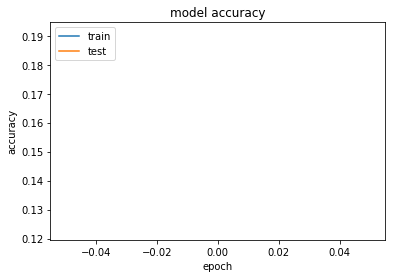

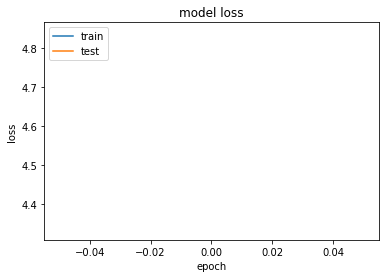

In [49]:
# Summarize history for accuracy
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [50]:
predictions = vqa_model.predict(x_val)

In [51]:
res = text_vision.predictions_to_dic(predictions, text_vision.test_questions_ids[:n_test])
res

[{'answer': u'yes', 'question_id': 3506232},
 {'answer': u'yes', 'question_id': 3506230},
 {'answer': u'yes', 'question_id': 3506231},
 {'answer': u'10', 'question_id': 86472},
 {'answer': u'yes', 'question_id': 86470},
 {'answer': u'yes', 'question_id': 86471},
 {'answer': u'yes', 'question_id': 4344100},
 {'answer': u'yes', 'question_id': 4344101},
 {'answer': u'10', 'question_id': 4344102},
 {'answer': u'10', 'question_id': 562050},
 {'answer': u'10', 'question_id': 562051},
 {'answer': u'yes', 'question_id': 562052},
 {'answer': u'10', 'question_id': 652272},
 {'answer': u'yes', 'question_id': 652270},
 {'answer': u'yes', 'question_id': 652271},
 {'answer': u'yes', 'question_id': 1034880},
 {'answer': u'yes', 'question_id': 1034881},
 {'answer': u'10', 'question_id': 1034882},
 {'answer': u'yes', 'question_id': 1240392},
 {'answer': u'10', 'question_id': 1240390},
 {'answer': u'yes', 'question_id': 1240391},
 {'answer': u'yes', 'question_id': 2002960},
 {'answer': u'10', 'question_

In [53]:
answers_ind_val_true = np.argmax(y_val, axis=1)
idx_to_answer = np.vectorize(text_vision.idx_to_answer)
idx_to_answer(answers_ind_val_true)

array([u'wood', u'no', u'None', ..., u'no', u'coffee', u'kitchen'],
      dtype='<U18')